In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from shapely.geometry import Point
import geopandas as gpd
import os
import random

In [2]:
# Load the data from CSV file
data = pd.read_csv(r"./Daily_HAI_Mean.csv")

# Preprocess the data
data['date'] = pd.to_datetime(data['ds'])
data['latitude'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

In [3]:
data.head()

,ds,Lat,Lon,y,unique_id,date,latitude,longitude,activity_index
0,2020-01-01,51.728440,7.333657,0.117984,1,2020-01-01,0.399589,0.344182,0.605971
1,2020-01-02,51.745312,7.324808,0.128913,1,2020-01-02,0.612946,0.244590,0.924800
2,2020-01-03,51.736941,7.322903,0.123177,1,2020-01-03,0.507084,0.223151,0.757461
3,2020-01-04,51.736578,7.307931,0.125445,1,2020-01-04,0.502494,0.054646,0.823631
4,2020-01-05,51.744239,7.330141,0.113853,1,2020-01-05,0.599377,0.304618,0.485474


In [26]:
# Split data into train and test sets (considering dates)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 4  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers

In [27]:
def prepare_data(data):
    X = []
    y = []
    data = data.sort_values(by='date')  # Sort data by date
    for i in range(len(data) - seq_length):
        X.append(data[['latitude', 'longitude', 'activity_index']].iloc[i:i+seq_length].values)
        y.append(data['activity_index'].iloc[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y


In [28]:
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Reshape the data for ConvLSTM
print("Before reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1, n_features, 1)

print("After reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Before reshaping:
X_train shape: (285, 7, 3)
X_test shape: (67, 7, 3)
After reshaping:
X_train shape: (285, 7, 1, 3, 1)
X_test shape: (67, 7, 1, 3, 1)


In [46]:
# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1), return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=2*n_filters, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=4*n_filters, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=8*n_filters, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=16*n_filters, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    Dense(1)  # Output layer
])

In [47]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_35 (ConvLSTM2D  (None, 7, 1, 3, 4)        96        
 )                                                               
                                                                 
 batch_normalization_35 (Ba  (None, 7, 1, 3, 4)        16        
 tchNormalization)                                               
                                                                 
 conv_lstm2d_36 (ConvLSTM2D  (None, 7, 1, 3, 8)        416       
 )                                                               
                                                                 
 batch_normalization_36 (Ba  (None, 7, 1, 3, 8)        32        
 tchNormalization)                                               
                                                                 
 conv_lstm2d_37 (ConvLSTM2D  (None, 7, 1, 3, 16)      

In [48]:
# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), verbose = 1)

Epoch 1/25
9/9 [==============================] - 10s 148ms/step - loss: 0.5908 - val_loss: 0.1514
Epoch 2/25
9/9 [==============================] - 0s 45ms/step - loss: 0.2128 - val_loss: 0.0989
Epoch 3/25
9/9 [==============================] - 0s 43ms/step - loss: 0.1292 - val_loss: 0.0657
Epoch 4/25
9/9 [==============================] - 0s 42ms/step - loss: 0.0959 - val_loss: 0.0464
Epoch 5/25
9/9 [==============================] - 0s 39ms/step - loss: 0.0656 - val_loss: 0.0370
Epoch 6/25
9/9 [==============================] - 0s 51ms/step - loss: 0.0567 - val_loss: 0.0332
Epoch 7/25
9/9 [==============================] - 0s 41ms/step - loss: 0.0531 - val_loss: 0.0315
Epoch 8/25
9/9 [==============================] - 0s 44ms/step - loss: 0.0472 - val_loss: 0.0315
Epoch 9/25
9/9 [==============================] - 0s 41ms/step - loss: 0.0446 - val_loss: 0.0317
Epoch 10/25
9/9 [==============================] - 0s 41ms/step - loss: 0.0430 - val_loss: 0.0326
Epoch 11/25
9/9 [==========

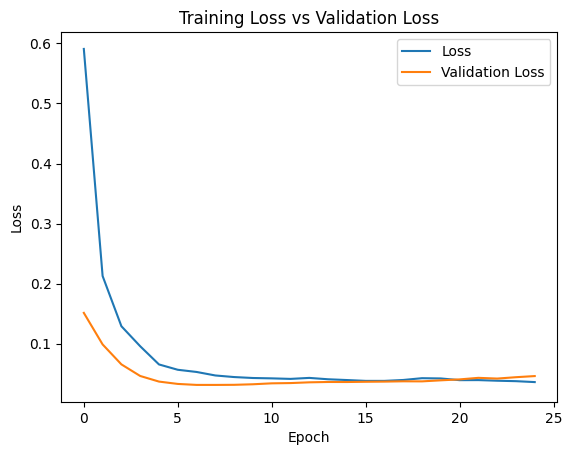

In [49]:
# Plot loss vs validation loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.show()

In [58]:
y_test, y_pred[:, 0, 0]

(array([0.77810245, 0.7919413 , 0.60214493, 0.73840159, 0.84892502,
        0.54719672, 0.6268909 , 0.72904251, 0.65937768, 0.75231192,
        0.76197653, 0.75084518, 0.57038933, 0.49536178, 0.63756828,
        0.58254877, 0.31786156, 0.38456348, 0.3783364 , 0.44423318,
        0.46848893, 0.09826009, 0.44119091, 0.3957823 , 0.38952665,
        0.47577773, 0.11940039, 0.27623277, 0.37302389, 0.4255243 ,
        0.41032183, 0.41623751, 0.17457085, 0.35117619, 0.42303026,
        0.47060499, 0.1817805 , 0.10483846, 0.        , 0.33221814,
        0.32924496, 0.29982044, 0.34726227, 0.40471321, 0.33908897,
        0.32236382, 0.36920888, 0.33463063, 0.37218145, 0.30203362,
        0.52187073, 0.3270936 , 0.42256182, 0.38527735, 0.42609197,
        0.47961131, 0.41521619, 0.47888308, 0.35171019, 0.46753726,
        0.50507474, 0.40009076, 0.39076869, 0.38316694, 0.47321681,
        0.49151132, 0.33537774]),
 array([0.307907  , 0.30774677, 0.30825546, 0.30827975, 0.3087626 ,
        0.3084

In [62]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test)#.reshape(-1)
y_pred = y_pred[:, 0, 0]

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

3/3 [==============================] - 0s 5ms/step - loss: 0.0462
Test Loss: 0.04622521623969078
3/3 [==============================] - 0s 4ms/step
0.04622775589088038 -0.5582745187325024


In [70]:
y_pred = y_pred[:, 0]
y_pred

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

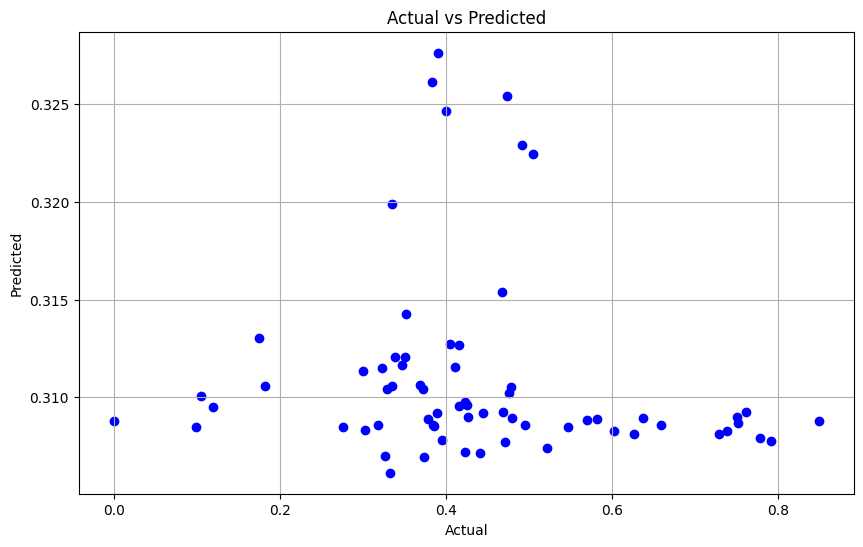

ValueError: x and y must be the same size

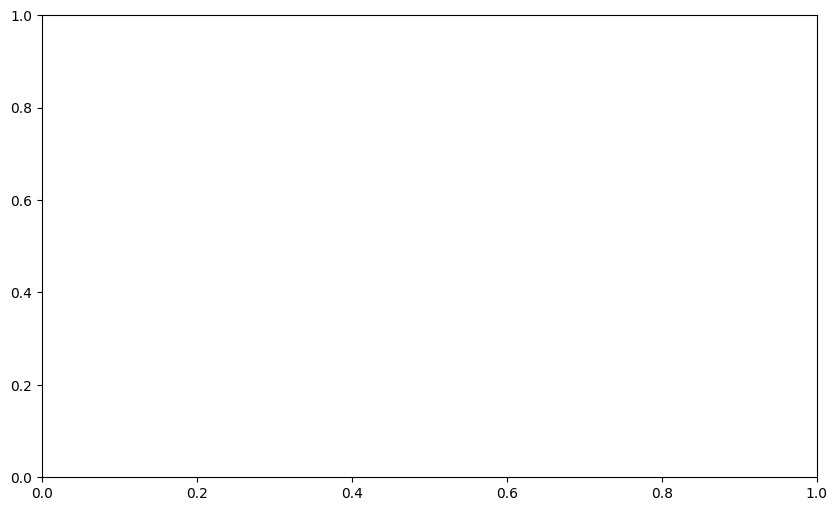

In [65]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from shapely.geometry import Point
import geopandas as gpd
import os
import random

# Load the data from CSV file
data = pd.read_csv(r"./Daily_HAI_Mean.csv")

# Preprocess the data
data['date'] = pd.to_datetime(data['ds'])
data['latitude'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

# Split data into train and test sets (considering dates)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 32  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers

# Prepare the data for ConvLSTM
def prepare_data(data):
    X = []
    y = []
    data = data.sort_values(by='date')  # Sort data by date
    for i in range(len(data) - seq_length):
        X.append(data[['latitude', 'longitude', 'activity_index']].iloc[i:i+seq_length].values)
        y.append(data['activity_index'].iloc[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Reshape the data for ConvLSTM
print("Before reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1,  n_features, 1)

print("After reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1), return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=64, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=128, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=256, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=512, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    Dense(1)  # Output layer
])


# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test).reshape(-1)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot loss vs validation loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Save test data and predicted values to CSV
test_df = pd.DataFrame({'Actual_Activity_Index': y_test, 'Predicted_Activity_Index': y_pred,
                        'Latitude': test_data['Lat'][-len(y_test):].values,
                        'Longitude': test_data['Lon'][-len(y_test):].values,
                        'Date': test_data['date'][-len(y_test):].values})
test_df.to_csv('test_predicted_values.csv', index=False)

# Convert CSV to shapefile
geometry = [Point(xy) for xy in zip(test_df['Longitude'], test_df['Latitude'])]
gdf = gpd.GeoDataFrame(test_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf.to_file('test_predicted_values.shp')

# Generate random data for prediction
random_data = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-01', end='2023-01-10'),
    'Lat': np.random.uniform(low=data['Lat'].min(), high=data['Lat'].max(), size=(10,)),
    'Lon': np.random.uniform(low=data['Lon'].min(), high=data['Lon'].max(), size=(10,))
})

# Prepare random data for prediction
X_random, _ = prepare_data(random_data)
X_random = X_random.reshape(-1, seq_length, 1, n_features, 1)

# Make predictions on random data
y_random_pred = model.predict(X_random).reshape(-1)

# Combine random data with predicted values
random_pred_df = pd.DataFrame({'Predicted_Activity_Index': y_random_pred,
                               'Latitude': random_data['Lat'].values,
                               'Longitude': random_data['Lon'].values,
                               'Date': random_data['Date'].values})

# Save random data and predicted values to CSV
random_pred_df.to_csv('random_predicted_values.csv', index=False)

# Convert random data CSV to shapefile
geometry_random = [Point(xy) for xy in zip(random_pred_df['Longitude'], random_pred_df['Latitude'])]
gdf_random = gpd.GeoDataFrame(random_pred_df, geometry=geometry_random)
gdf_random.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf_random.to_file('random_predicted_values.shp')
